# Tephra Inversion Framework Demo

This notebook demonstrates the functionality of all components in the tephra inversion framework.

In [1]:
# Cell 1: Setup and Imports
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Import framework components
from scripts.data_handling.wind_data import WindDataHandler
from scripts.data_handling.parameter_input import ParameterHandler
from scripts.data_handling.observation_data import ObservationHandler
from scripts.core.tephra2_interface import Tephra2Interface
from scripts.core.lhs import LatinHypercubeSampler
from scripts.core.mcmc import (
    metropolis_hastings,
    compute_posterior,
    run_tephra2,
    changing_variable,
    draw_input_parameter,
    prior_function,
    likelihood_function
)
from scripts.visualization.wind_plots import WindPlotter
from scripts.visualization.observation_plots import ObservationPlotter
from scripts.visualization.diagnostic_plots import DiagnosticPlotter

# Set matplotlib style
sns.set_style('whitegrid')
sns.set_context('notebook')
%matplotlib inline

2025-04-27 19:39:06,889 - arviz - INFO - Found 'auto' as default backend, checking available backends
2025-04-27 19:39:06,889 - arviz - INFO - Matplotlib is available, defining as default backend
2025-04-27 19:39:06,893 - arviz.preview - INFO - arviz_base available, exposing its functions as part of arviz.preview
2025-04-27 19:39:07,689 - arviz.preview - INFO - arviz_stats available, exposing its functions as part of arviz.preview
2025-04-27 19:39:07,704 - arviz.preview - INFO - arviz_plots available, exposing its functions as part of arviz.preview


In [2]:
# Cell 2: Directory Setup
# Create required directories
os.makedirs('data/input', exist_ok=True)
os.makedirs('data/output/plots', exist_ok=True)
os.makedirs('config', exist_ok=True)

print("Directory structure created:")
!tree -L 3

Directory structure created:
.
├── README.md
├── config
│   ├── default_config.yaml
│   └── wind_params.yaml
├── data
│   ├── input
│   │   ├── esp_input.csv
│   │   ├── observations.csv
│   │   ├── sites.csv
│   │   └── wind.txt
│   └── output
│       ├── mcmc
│       └── plots
├── demo.ipynb
├── requirements.txt
├── scripts
│   ├── core
│   │   ├── __pycache__
│   │   ├── lhs.py
│   │   ├── mcmc.py
│   │   └── tephra2_interface.py
│   ├── data_handling
│   │   ├── __pycache__
│   │   ├── observation_data.py
│   │   ├── parameter_input.py
│   │   └── wind_data.py
│   └── visualization
│       ├── __pycache__
│       ├── diagnostic_plots.py
│       ├── observation_plots.py
│       └── wind_plots.py
├── tephra2
└── tinvvenv
    ├── bin
    │   ├── Activate.ps1
    │   ├── activate
    │   ├── activate.csh
    │   ├── activate.fish
    │   ├── black
    │   ├── blackd
    │   ├── cartopy_feature_download
    │   ├── debugpy
    │   ├── debugpy-adapter
    │   ├── dmypy
    │   ├── f2py
 

In [3]:
# Cell 5: Parameter Configuration
# Initialize parameter handler
param_handler = ParameterHandler()

# Get default parameters
params = param_handler._get_default_params()

# Save parameters
param_handler.save_parameters(params, 'esp_input.csv')

# Load and validate parameters
loaded_params = param_handler.load_parameters('esp_input.csv')
print("Loaded parameters:")
print(loaded_params)


Parameters saved to: data/input/esp_input.csv
Loaded parameters:
{'params': {'column_height': {'initial_val': 12500.0, 'prior_type': 'Uniform', 'prior_para_a': 5000.0, 'prior_para_b': 20000.0, 'draw_scale': 150.0}, 'log_m': {'initial_val': 22.5, 'prior_type': 'Uniform', 'prior_para_a': 20.0, 'prior_para_b': 25.0, 'draw_scale': 0.05}, 'alpha': {'initial_val': 3.0, 'prior_type': 'Uniform', 'prior_para_a': 1.0, 'prior_para_b': 5.0, 'draw_scale': 0.04}, 'beta': {'initial_val': 2.0, 'prior_type': 'Uniform', 'prior_para_a': 1.0, 'prior_para_b': 3.0, 'draw_scale': 0.02}}, 'fixed': {'diffusion_coefficient': 1000.0, 'fall_time_threshold': 100.0}, 'use_lhs': False}


In [4]:
# Initialize wind data handler
wind_handler = WindDataHandler()

# Load parameters from YAML
params = wind_handler.load_params_from_yaml('config/wind_params.yaml')

# Generate synthetic wind data
wind_data = wind_handler.generate_wind_data(params)

# Save wind data
wind_handler.save_wind_data(wind_data, 'wind.txt')

# Load and validate wind data
loaded_wind_data = wind_handler.load_wind_data('data/input/wind.txt')
print("\nWind data loaded successfully:")
print(loaded_wind_data.head())


Wind data saved to: data/input/wind.txt

Wind data loaded successfully:
   HEIGHT  SPEED  DIRECTION
0     0.0    4.1      150.0
1  1000.0    8.3      150.0
2  2000.0   14.6      150.0
3  3000.0   21.8      150.0
4  4000.0   27.7      150.0


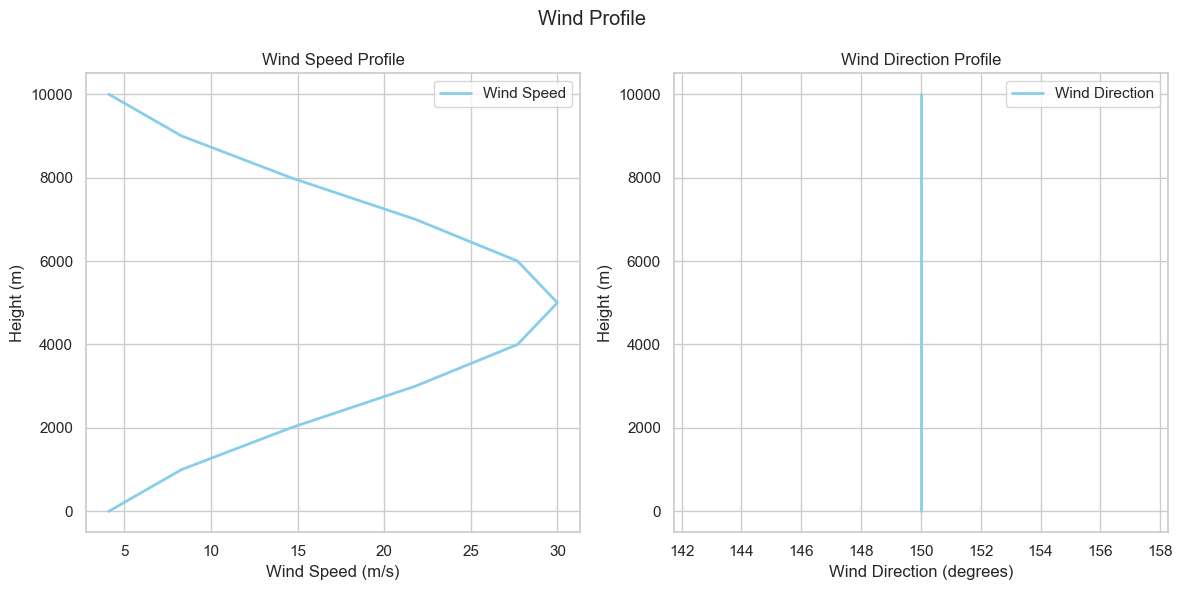

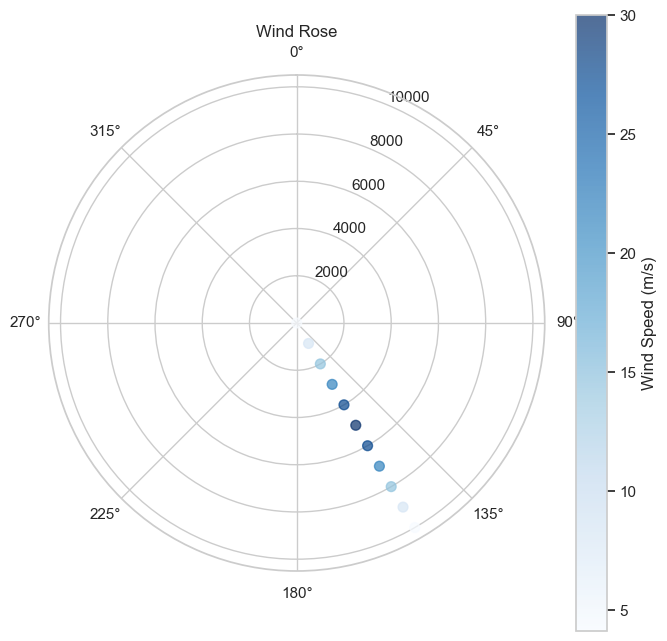

Wind visualizations saved to data/output/plots/


In [5]:
# Cell 4: Wind Visualization
# Initialize wind plotter
wind_plotter = WindPlotter()

# Extract data from DataFrame
heights = loaded_wind_data['HEIGHT'].values
speeds = loaded_wind_data['SPEED'].values
directions = loaded_wind_data['DIRECTION'].values

# Generate wind profile plots
wind_plotter.plot_wind_profile(
    heights=heights,
    speeds=speeds,
    directions=directions,
    title="Wind Profile"
)

# Generate wind rose plot
wind_plotter.plot_wind_rose(
    directions=directions,
    speeds=speeds,
    heights=heights,
    title="Wind Rose"
)

print("Wind visualizations saved to data/output/plots/")

In [6]:
# Cell 5: Parameter Configuration
# Initialize parameter handler
param_handler = ParameterHandler()

# Get default parameters
params = param_handler._get_default_params()

# Save parameters
param_handler.save_parameters(params, 'esp_input.csv')

# Load and validate parameters
loaded_params = param_handler.load_parameters('esp_input.csv')
print("Loaded parameters:")
print(loaded_params)


Parameters saved to: data/input/esp_input.csv
Loaded parameters:
{'params': {'column_height': {'initial_val': 12500.0, 'prior_type': 'Uniform', 'prior_para_a': 5000.0, 'prior_para_b': 20000.0, 'draw_scale': 150.0}, 'log_m': {'initial_val': 22.5, 'prior_type': 'Uniform', 'prior_para_a': 20.0, 'prior_para_b': 25.0, 'draw_scale': 0.05}, 'alpha': {'initial_val': 3.0, 'prior_type': 'Uniform', 'prior_para_a': 1.0, 'prior_para_b': 5.0, 'draw_scale': 0.04}, 'beta': {'initial_val': 2.0, 'prior_type': 'Uniform', 'prior_para_a': 1.0, 'prior_para_b': 3.0, 'draw_scale': 0.02}}, 'fixed': {'diffusion_coefficient': 1000.0, 'fall_time_threshold': 100.0}, 'use_lhs': False}


In [7]:
# Cell 6: Observation Data
# Initialize observation handler
obs_handler = ObservationHandler()

# Define observation parameters
obs_params = {
    "source": "synthetic",
    "n_points": 100,
    "noise_level": 0.1,
    "grid_spacing": 1000,  # meters
    "max_distance": 50000  # meters
}

# Generate synthetic observations
observations, sites = obs_handler.generate_observations(obs_params)

# Save observations and sites
obs_handler.save_observations(observations, sites)

# Load and validate observations
loaded_obs = pd.read_csv('data/input/observations.csv')
print("Observations shape:", loaded_obs.shape)
print("First few rows:")
print(loaded_obs.head())


Observations saved to: data/input/observations.csv
Sites saved to: data/input/sites.csv
Observations shape: (99, 1)
First few rows:
   15.860754
0  23.367493
1  32.290223
2  31.884199
3  36.504097
4  33.766303


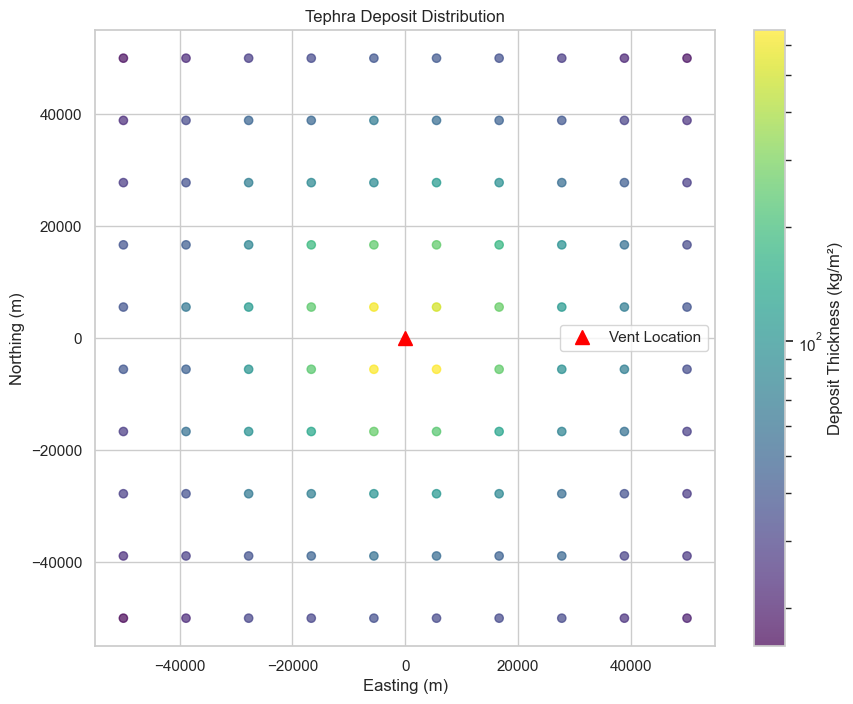

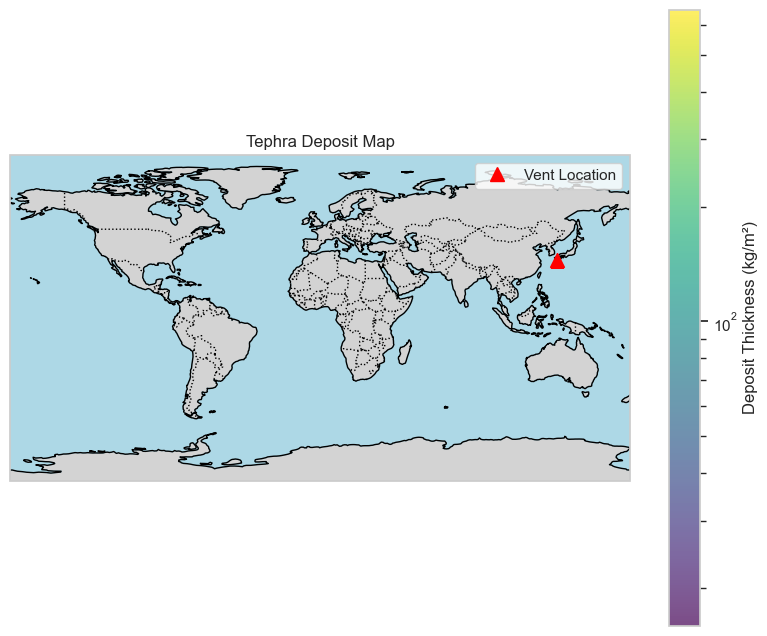

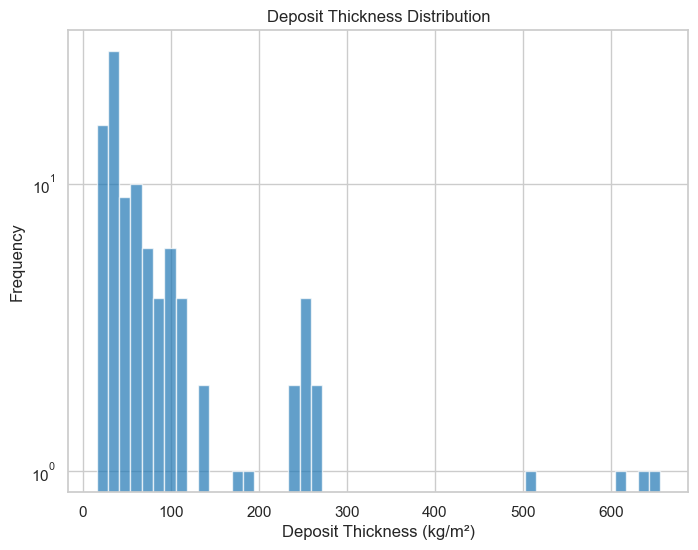

Observation visualizations saved to data/output/plots/


In [8]:
# Cell 7: Observation Visualization
# Initialize observation plotter
obs_plotter = ObservationPlotter()

# Define vent location (example coordinates)
vent_location = (0.0, 0.0)  # (easting, northing)
vent_lat, vent_lon = 31.93, 130.93  # (latitude, longitude)

# Plot tephra distribution
obs_plotter.plot_tephra_distribution(
    sites[:, 0],  # eastings
    sites[:, 1],  # northings
    observations,  # thicknesses
    vent_location
)

# Plot tephra map
obs_plotter.plot_tephra_map(
    sites[:, 1],  # lats (using northing as latitude for example)
    sites[:, 0],  # lons (using easting as longitude for example)
    observations,  # thicknesses
    vent_lat,
    vent_lon
)

# Plot thickness histogram
obs_plotter.plot_thickness_histogram(observations)

print("Observation visualizations saved to data/output/plots/")

In [ ]:
# Cell 8: Tephra2 Interface
# Initialize Tephra2 interface
tephra2 = Tephra2Interface()

# Create configuration
config = tephra2.create_config(
    vent_lat=31.93,
    vent_lon=130.93,
    wind_data=loaded_wind
)

# Run forward model
result = tephra2.run_forward_model(
    vent_lat=31.93,
    vent_lon=130.93,
    wind_data=loaded_wind,
    model_params=loaded_params
)

print("Tephra2 output shape:", result.shape)
print("First few data points:")
print(result.head())

In [ ]:
# Cell 9: LHS Search
# Initialize LHS sampler
lhs_sampler = LatinHypercubeSampler()

# Define parameter ranges
param_ranges = {
    'plume_height': (1000, 5000),
    'eruption_mass': (1e10, 1e12),
    'wind_speed': (5, 20),
    'wind_direction': (0, 360)
}

# Generate samples
samples = lhs_sampler.generate_samples(param_ranges, n_samples=100)

# Evaluate samples
results = lhs_sampler.evaluate_samples(samples, tephra2.run_forward_model)

print("LHS samples shape:", samples.shape)
print("Results shape:", results.shape)

In [ ]:
# Cell 10: MCMC Inversion
# Define MCMC parameters
n_iterations = 1000
n_burnin = 100
likelihood_scale = 0.1
check_snapshot = 100

# Define prior types and parameters
prior_type = np.array(['Gaussian'] * len(param_ranges))
prior_para = np.array([
    [3000, 1000],  # plume_height
    [1e11, 1e10],  # eruption_mass
    [10, 5],       # wind_speed
    [180, 90]      # wind_direction
])

# Define draw scales
draw_scale = np.array([100, 1e9, 1, 10])  # Adjust based on parameter sensitivity

# Run MCMC
chain, post_chain, acceptance_count, prior_array, likeli_array = metropolis_hastings(
    input_params=np.array([3000, np.log(1e11), 10, 180]),  # Initial parameters
    prior_type=prior_type,
    draw_scale=draw_scale,
    prior_para=prior_para,
    config_path='config/tephra2_config.txt',
    sites_path='data/input/sites.csv',
    wind_path='data/input/wind.txt',
    output_path='data/output/tephra2_output.txt',
    tephra2_path='tephra2_2020',  # Update this path
    runs=n_iterations,
    likelihood_scale=likelihood_scale,
    observation=loaded_obs['mass'].values,
    check_snapshot=check_snapshot
)

print(f"MCMC completed with acceptance rate: {acceptance_count / n_iterations:.4f}")
print("Chain shape:", chain.shape)

In [ ]:
# Cell 11: Diagnostic Plots
# Initialize diagnostic plotter
diag_plotter = DiagnosticPlotter()

# Generate diagnostic plots
diag_plotter.plot_traces(chain)
diag_plotter.plot_autocorrelation(chain)
diag_plotter.plot_parameter_distributions(chain)
diag_plotter.plot_parameter_correlations(chain)
diag_plotter.plot_tephra_distribution(loaded_obs, result)
diag_plotter.plot_parameter_evolution(chain)
diag_plotter.plot_effective_sample_size(chain)
diag_plotter.plot_rhat(chain)

print("Diagnostic plots saved to data/output/plots/")